# **Mengambil tema Model AI menggunakan Natural Language Processing yang Berjudul : Deteksi Hate Speech dengan BERT.**

# **1: Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2: Install Library**

In [ ]:
!pip install transformers datasets sklearn pandas --quiet

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# **3: Import Library**

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

# **4: Load Dataset dari Google Drive**

In [24]:
dataset_path = os.path.join('/content/labeled_data.csv')

# Load dataset
df = pd.read_csv(dataset_path)

# Ambil kolom penting dan ubah nama
df = df[['tweet', 'class']]
df.columns = ['text', 'label']

# Cek data
df['label'].value_counts()
df.head()


,text,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


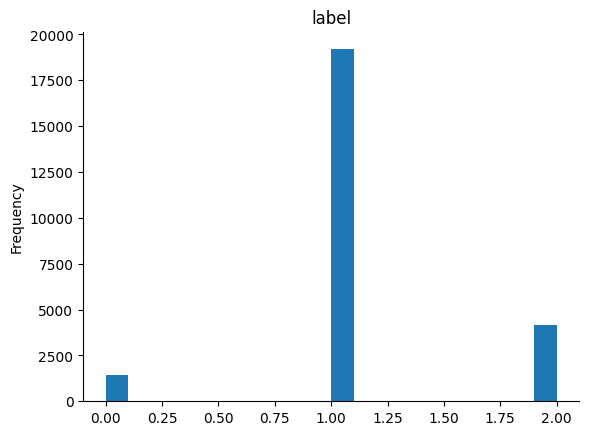

In [ ]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

# **5: Preprocessing & Tokenisasi**

In [25]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenisasi
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

# Konversi ke Hugging Face Datasets
train_dataset = Dataset.from_dict({**train_encodings, "label": list(train_labels)})
val_dataset = Dataset.from_dict({**val_encodings, "label": list(val_labels)})


# **6: Load Model BERT**

In [26]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Karena training error disebab harus update library transformers ke versi terbaru saya akan buat caranya diatas Training**

**Cara Updatenya**

In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import TrainingArguments, Trainer

# **7: Training**

In [27]:
from transformers import TrainingArguments, Trainer
from transformers import BertForSequenceClassification
# Load Model BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-27-2378144331.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **8: Evaluasi Model**

In [28]:
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print(classification_report(y_true, y_pred, target_names=['Hate Speech', 'Offensive', 'Neither']))


              precision    recall  f1-score   support

 Hate Speech       0.06      0.01      0.02       290
   Offensive       0.77      0.01      0.02      3832
     Neither       0.17      0.98      0.29       835

    accuracy                           0.17      4957
   macro avg       0.33      0.33      0.11      4957
weighted avg       0.63      0.17      0.07      4957



# **Simpan Model**

In [29]:
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# **Uji Model dengan Input Manual**

In [31]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax().item()
    return predicted_class

predict("This is a horrible message!")  # Output: 0 / 1 / 2 tergantung labelmu

2

# **Buat Interface Sederhana**

In [30]:
import gradio as gr

def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    label = outputs.logits.argmax().item()
    return ["Hate Speech", "Offensive", "Neither"][label]

gr.Interface(fn=classify_text, inputs="text", outputs="text").launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2a485bff3e21f5349c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
